In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from util import *

In [2]:
# Configuration
file_directory = 'dataset/'
normal_file = file_directory + 'swat_normal_dataset.csv'
attack_file = file_directory + 'swat_attack_dataset.csv'
list_attack_file = file_directory + 'list_of_attack.csv'
sample_rate = '1T'

# Time periods
period_training = ['2015-12-23 00:00:00', '2015-12-25 23:59:59']
period_validation = ['2015-12-26 00:00:00', '2015-12-26 23:59:59']
period_attack = ['2015-12-28 10:00:00', '2015-12-29 09:59:59']

# Variables
target = 'LIT101'
features = ['FIT101', 'MV101', 'P101', 'P102']

# Hyperparameters
length = 10
number_layers = 3
hidden_neurons = 100
batch_size = 300
number_epoch = 30
learning_rate = 0.001
activation_function = 'tanh'

# Data Preparation

In [3]:
# Load input file
normal_data = pd.read_csv(normal_file)
attack_data = pd.read_csv(attack_file)
list_attack = pd.read_csv(list_attack_file)

In [4]:
# Change data type of a few columns
for data in [normal_data, attack_data]:
    data['Timestamp'] = pd.to_datetime(
        data.Timestamp, 
        errors='coerce', 
        dayfirst=True
    )
    data['Status'] = data['Status'].astype('category')

for column in ['start_time', 'end_time']:
    list_attack[column] = pd.to_datetime(
        list_attack[column], 
        errors='coerce', 
        dayfirst=True
    )

In [5]:
# Downsampling
normal_data = resample(normal_data, sample_rate)
attack_data = resample(attack_data, sample_rate)

In [6]:
# Split data into training, validation, and attack set
training_data = filter_time(
    normal_data, 
    start_date=period_training[0], 
    end_date=period_training[1]
)
validation_data = filter_time(
    normal_data, 
    start_date=period_validation[0], 
    end_date=period_validation[1]
)
attack_data = filter_time(
    attack_data, 
    start_date=period_attack[0], 
    end_date=period_attack[1]
)

In [7]:
# Feature selection
x_train = training_data.filter(items=features).values.tolist()
y_train = training_data[target].values.tolist()

x_validation = validation_data.filter(items=features).values.tolist()
y_validation = validation_data[target].values.tolist()

x_attack = attack_data.filter(items=features).values.tolist()
y_attack = attack_data[target].values.tolist()

# Modeling using Linear Regression

In [8]:
# Train linear model
model = lm.LinearRegression(normalize=True)
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

# Evaluation

In [9]:
# Make prediction using the model
y_prediction = model.predict(x_validation)

In [10]:
# Evaluate
error = y_prediction.flatten() - np.array(y_validation).flatten()
max_error = max(error)
min_error = min(error)
rmse = sqrt(mean_squared_error(y_prediction, y_validation))
print("Root mean square error (RMSE): ", round(rmse, 2))
print("Maximum error: ", round(max_error, 2))
print("Minimum error: ", round(min_error, 2))

Root mean square error (RMSE):  53.36
Maximum error:  204.09
Minimum error:  -160.27


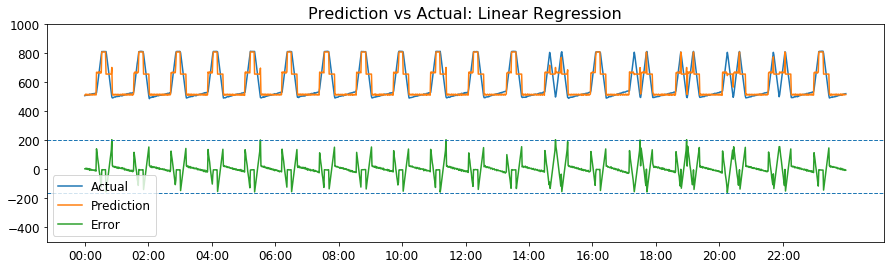

In [11]:
# Plot prediction vs actual
plot_comparison(
    y_validation, 
    y_prediction, 
    error, 
    max_error,
    min_error,
    validation_data,
    "Prediction vs Actual: Linear Regression"
)

# Anomaly Detection with Linear Regression

In [12]:
# Make prediction using attack data
y_prediction = model.predict(x_attack)

In [13]:
# Evaluate
error = y_prediction.flatten() - np.array(y_attack).flatten()
rmse = sqrt(mean_squared_error(y_prediction, y_attack))
print("Root mean square error (RMSE): ", round(rmse, 2))

Root mean square error (RMSE):  71.52


In [14]:
# Get list of attacks (represented by indices)
attack_indices = get_attacks(list_attack, attack_data)

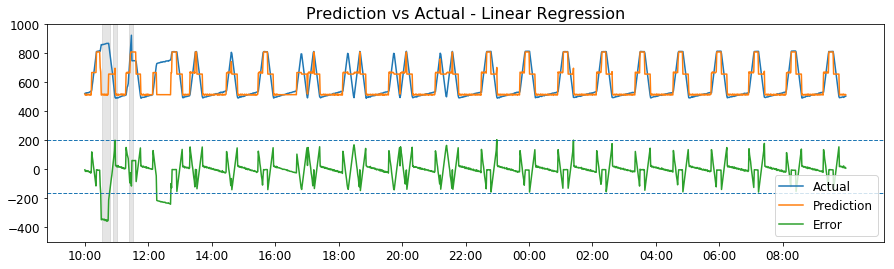

In [15]:
# Plot prediction vs actual
# The grey shades indicate when anomalies occured
plot_comparison(
    y_attack, 
    y_prediction, 
    error, 
    max_error,
    min_error,
    attack_data,
    "Prediction vs Actual - Linear Regression",
    attack_indices=attack_indices
)

# Modeling using Recurrenct Neural Networks

In [16]:
# Normalize the input variables (only based on training data distribution)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_validation = scaler.transform(x_validation)
x_attack = scaler.transform(x_attack)

In [17]:
# Convert to sequential data
x_train, y_train = get_sequences(x_train, y_train, length)
x_validation, y_validation = get_sequences(x_validation, y_validation, length)
x_attack, y_attack = get_sequences(x_attack, y_attack, length)

In [18]:
# Initialize the model
model = nn(
    input_neurons=len(features),
    hidden_neurons=hidden_neurons,
    length=length,
    number_layers=number_layers,
    output_neurons=1,
    learning_rate=learning_rate
)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [19]:
# Train the model with the training data
model.train(
    x_train,
    y_train,
    test_features=x_validation,
    test_targets=y_validation,
    epochs=number_epoch,
    batch_size=batch_size
)

Epoch: 1 of 30, validation error: 114.63
Epoch: 2 of 30, validation error: 110.36
Epoch: 3 of 30, validation error: 110.25
Epoch: 4 of 30, validation error: 110.42
Epoch: 5 of 30, validation error: 110.58
Epoch: 6 of 30, validation error: 110.25
Epoch: 7 of 30, validation error: 110.27
Epoch: 8 of 30, validation error: 110.55
Epoch: 9 of 30, validation error: 110.29
Epoch: 10 of 30, validation error: 110.28
Epoch: 11 of 30, validation error: 110.04
Epoch: 12 of 30, validation error: 100.26
Epoch: 13 of 30, validation error: 66.09
Epoch: 14 of 30, validation error: 43.41
Epoch: 15 of 30, validation error: 35.41
Epoch: 16 of 30, validation error: 72.90
Epoch: 17 of 30, validation error: 27.68
Epoch: 18 of 30, validation error: 21.98
Epoch: 19 of 30, validation error: 19.02
Epoch: 20 of 30, validation error: 16.79
Epoch: 21 of 30, validation error: 15.95
Epoch: 22 of 30, validation error: 15.00
Epoch: 23 of 30, validation error: 14.82
Epoch: 24 of 30, validation error: 13.34
Epoch: 25 of 

# Evaluation

In [20]:
# Make prediction using the model
y_prediction = model.predict(x_validation)

In [21]:
# Evaluate
error = y_prediction.flatten() - np.array(y_validation).flatten()
max_error = max(error)
min_error = min(error)
rmse = sqrt(mean_squared_error(y_prediction, y_validation))
print("Root mean square error (RMSE): ", round(rmse, 2))
print("Maximum error: ", round(max_error, 2))
print("Minimum error: ", round(min_error, 2))

Root mean square error (RMSE):  11.21
Maximum error:  42.21
Minimum error:  -48.53


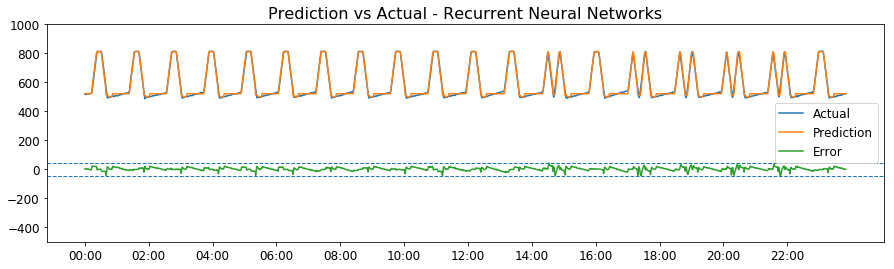

In [22]:
# Plot prediction vs actual
plot_comparison(
    y_validation, 
    y_prediction, 
    error, 
    max_error,
    min_error,
    validation_data,
    "Prediction vs Actual - Recurrent Neural Networks"
)

# Anomaly Detection with Recurrent Neural Networks

In [23]:
# Make prediction using attack data
y_prediction = model.predict(x_attack)

In [24]:
# Evaluate
error = y_prediction.flatten() - np.array(y_attack).flatten()
rmse = sqrt(mean_squared_error(y_prediction, y_attack))
print("Root mean square error (RMSE): ", round(rmse, 2))

Root mean square error (RMSE):  42.71


In [25]:
# Get list of attacks (represented by indices)
attack_indices = get_attacks(list_attack, attack_data, length=length)

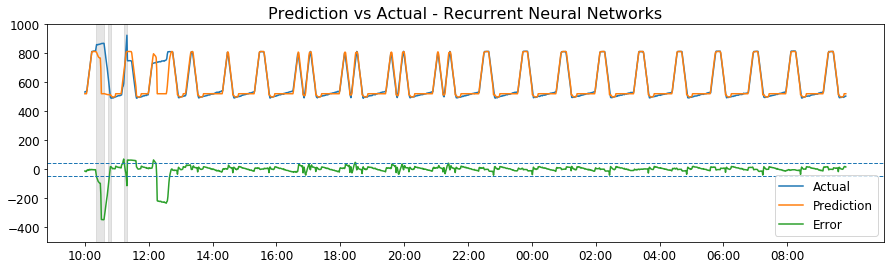

In [26]:
# Plot prediction vs actual
# The grey shades indicate when anomalies occured
plot_comparison(
    y_attack, 
    y_prediction, 
    error, 
    max_error,
    min_error,
    attack_data,
    "Prediction vs Actual - Recurrent Neural Networks",
    attack_indices=attack_indices
)